# Running this code

Please ensure you `make install` in the root directory to install all dependencies needed, and then you can point this notebook interpretter to the `.venv/bin/python` and it should run smoothly.

In [ ]:
from pathlib import Path
from typing import no_type_check

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import sep
from astropy.io import fits
from astropy.wcs import WCS
from loguru import logger
from matplotlib.patches import Ellipse
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm

from jades_sky_fraction.download import get_pearls_image

plt.rcParams["figure.dpi"] = 300

In [13]:
path = get_pearls_image()
hdul = fits.open(path)
wcs = WCS(hdul[0].header)

In [14]:
# Following Sep tutorial
data = hdul[0].data
data = data.astype(data.dtype.newbyteorder("="))
mask = data == 0

In [96]:
def apply_psf(data: np.ndarray, mask: np.ndarray, psf_mas: float) -> np.ndarray:
    if psf_mas == 0:
        return data
    # TODO: Im not sure if there's an easy way to do pixels->mas, or if I need to use the WCS.
    # mas_per_pixel = wcs.pixel_to_world(0, 0).separation(wcs.pixel_to_world(1, 0)).mas  # type: ignore  # noqa: PGH003
    # Ah, I note now that the image I downloaded has 30mas in the name, so the above giving 30 makes sense
    mas_per_pixel = 30
    gaussian_std_pixels = psf_mas / mas_per_pixel
    data_smooth = gaussian_filter(data, gaussian_std_pixels, mode="nearest")
    data_smooth[mask] = 0
    return data_smooth


psf_data = {i: apply_psf(data, mask, i) for i in [0, 30, 60, 90, 120, 150, 180, 210, 240]}

In [ ]:
@no_type_check
def plot_image(data: np.ndarray, wcs: WCS, objects: list):
    m, s = np.mean(data), np.std(data)

    ax = plt.subplot(projection=wcs, label="overlays")
    ax.imshow(data, interpolation="nearest", cmap="magma", vmin=m - s, vmax=m + 2 * s, origin="lower")
    ax.coords[0].set_axislabel("RA")
    ax.coords[1].set_axislabel("DEC")
    overlay = ax.get_coords_overlay("galactic")
    overlay.grid(color="white", ls="dotted")
    overlay[0].set_axislabel("Longitude")
    overlay[1].set_axislabel("Latitude")
    # plot an ellipse for each object
    for i in range(len(objects)):
        e = Ellipse(
            xy=(objects["x"][i], objects["y"][i]),
            width=6 * objects["a"][i],
            height=6 * objects["b"][i],
            angle=objects["theta"][i] * 180.0 / np.pi,
            linewidth=0.2,
        )
        e.set_facecolor("none")
        e.set_edgecolor("red")
        ax.add_artist(e)

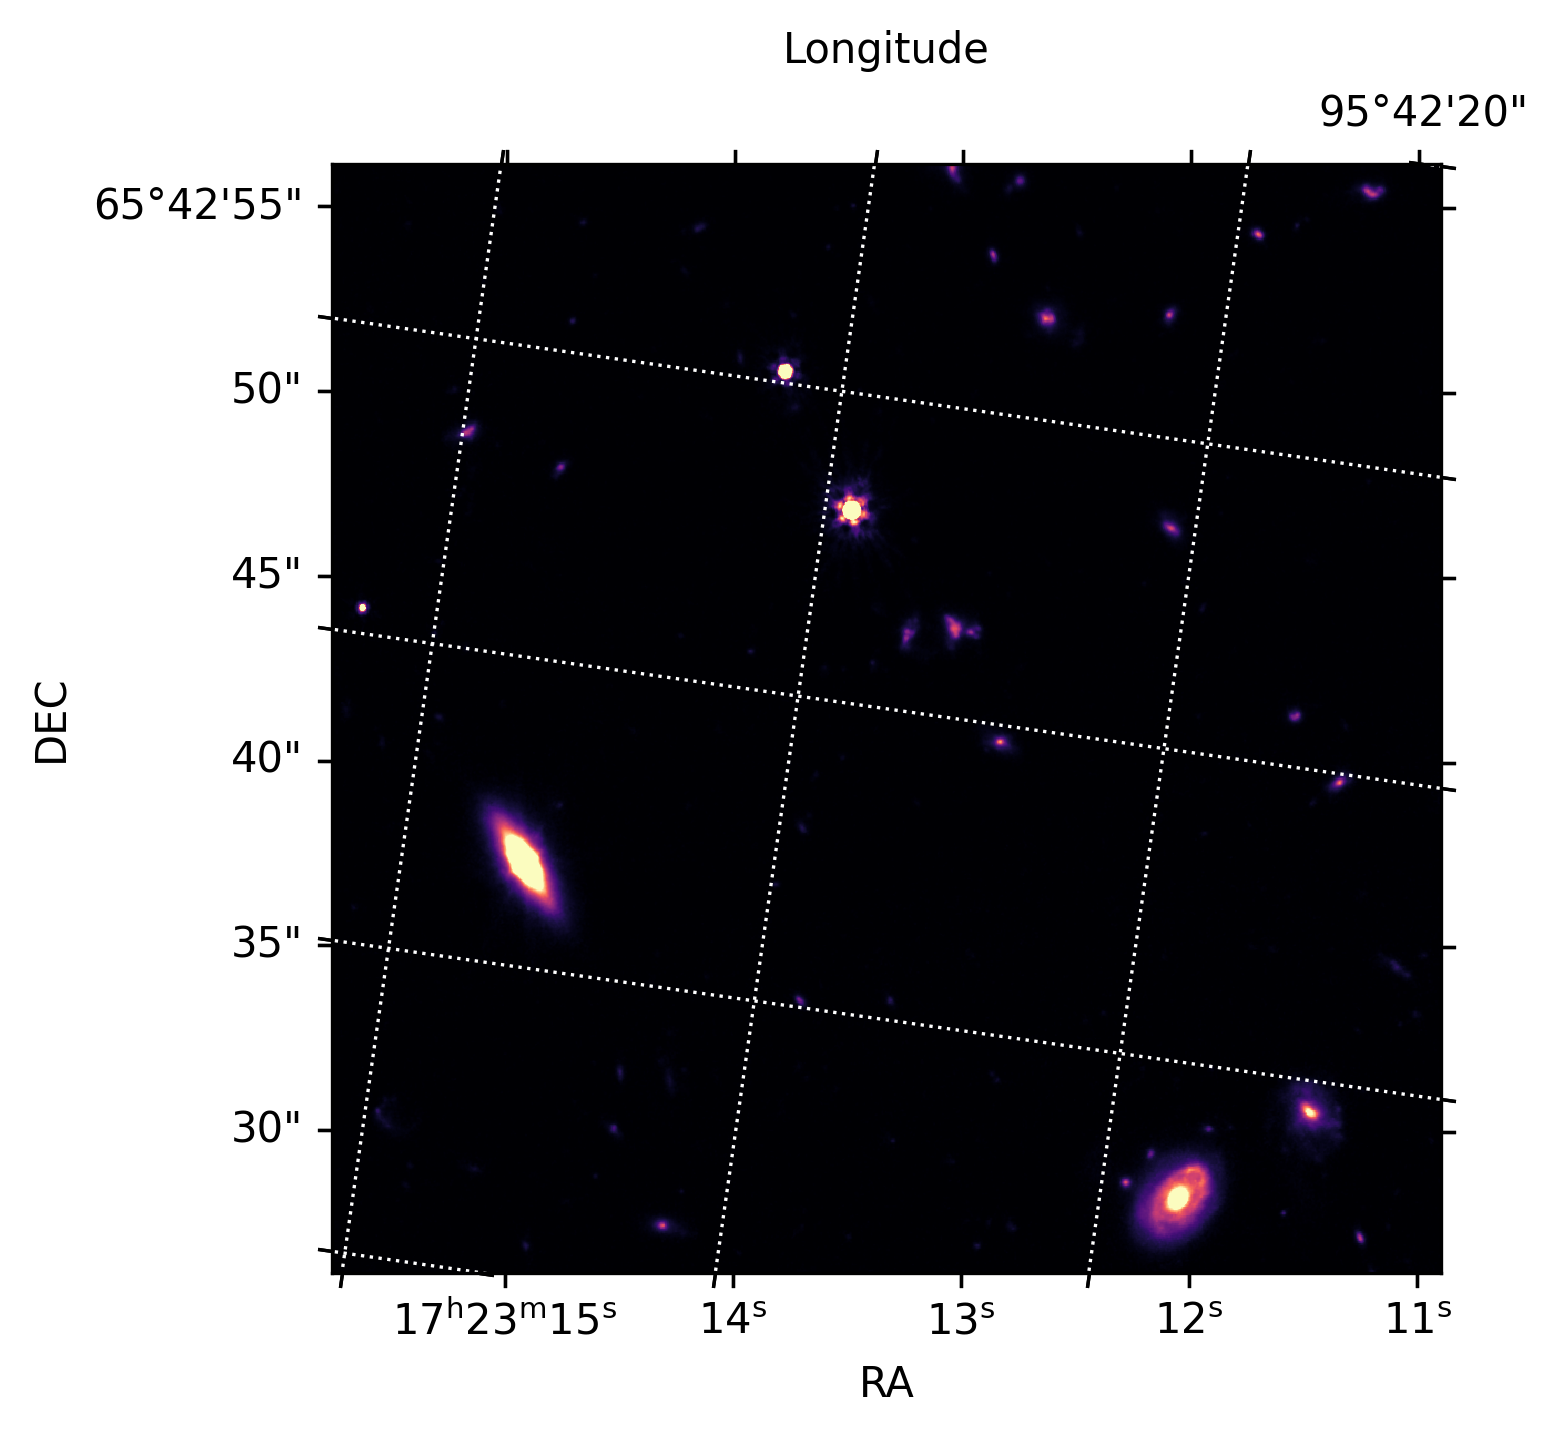

In [50]:
d = psf_data[0]
bkg = sep.Background(d, mask=mask)
data_sub = d - bkg
plot_image(data_sub[3000:4000, 3000:4000], wcs, [])

In [105]:
def get_sky_fraction_sep(
    data: np.ndarray,
    mask: np.ndarray,
    wcs: WCS,
    psf_mas: float = 0.0,
    plot: bool = False,
    significance: float = 2.0,
    deblend_cont: float = 0.001,
) -> pl.DataFrame:
    pix = psf_mas // 30
    bkg = sep.Background(data, mask=mask, bw=64 * (1 + pix), bh=64 * (1 + pix), fw=3 + pix, fh=3 + pix)
    data_sub = data - bkg
    logger.info(f"Extracting with psf_mas={psf_mas} and background rms {bkg.globalrms}")
    objects, segmentation_map = sep.extract(
        data_sub,
        significance,
        err=0.004,
        deblend_cont=deblend_cont,
        mask=mask,
        segmentation_map=True,
    )
    logger.info(f"Found {len(objects)} objects when extracting with psf_mas={psf_mas}")
    if plot:
        plot_image(data, wcs, objects)

    is_sky = segmentation_map == 0
    sky_percent = is_sky[~mask].mean()
    return pl.DataFrame({
        "sky_percent": sky_percent,
        "psf_mas": psf_mas,
        "sep_significance": significance,
        "deblend_cont": deblend_cont,
    })


dfs = []
deblending_conts = [0.01]
sigmas = [1.5, 2.0, 3.0]
psfs = list(psf_data.keys())
combinations = [(deblend, psf, sigma) for deblend in deblending_conts for psf in psfs for sigma in sigmas]
for _, (deblend, psf, sigma) in zip(tqdm(range(len(combinations))), combinations):
    dfs.append(get_sky_fraction_sep(psf_data[psf], mask, wcs, psf, significance=sigma, deblend_cont=deblend))

df = pl.concat(dfs, how="diagonal_relaxed")

  0%|          | 0/27 [00:00<?, ?it/s]

2025-02-14 18:41:57.979 | INFO     | __main__:get_sky_fraction_sep:13 - Extracting with psf_mas=0 and background rms 0.003952575847506523
2025-02-14 18:42:02.722 | INFO     | __main__:get_sky_fraction_sep:22 - Found 26947 objects when extracting with psf_mas=0
2025-02-14 18:42:03.858 | INFO     | __main__:get_sky_fraction_sep:13 - Extracting with psf_mas=0 and background rms 0.003952575847506523
2025-02-14 18:42:06.315 | INFO     | __main__:get_sky_fraction_sep:22 - Found 13874 objects when extracting with psf_mas=0
2025-02-14 18:42:07.507 | INFO     | __main__:get_sky_fraction_sep:13 - Extracting with psf_mas=0 and background rms 0.003952575847506523
2025-02-14 18:42:09.142 | INFO     | __main__:get_sky_fraction_sep:22 - Found 8816 objects when extracting with psf_mas=0
2025-02-14 18:42:09.774 | INFO     | __main__:get_sky_fraction_sep:13 - Extracting with psf_mas=30 and background rms 0.002595605794340372
2025-02-14 18:42:12.823 | INFO     | __main__:get_sky_fraction_sep:22 - Found 1

In [106]:
df

sky_percent,psf_mas,sep_significance,deblend_cont
f64,i64,f64,f64
0.927701,0,1.5,0.01
0.941308,0,2.0,0.01
0.955342,0,3.0,0.01
0.92106,30,1.5,0.01
0.935149,30,2.0,0.01
…,…,…,…
0.925633,210,2.0,0.01
0.94384,210,3.0,0.01
0.907305,240,1.5,0.01


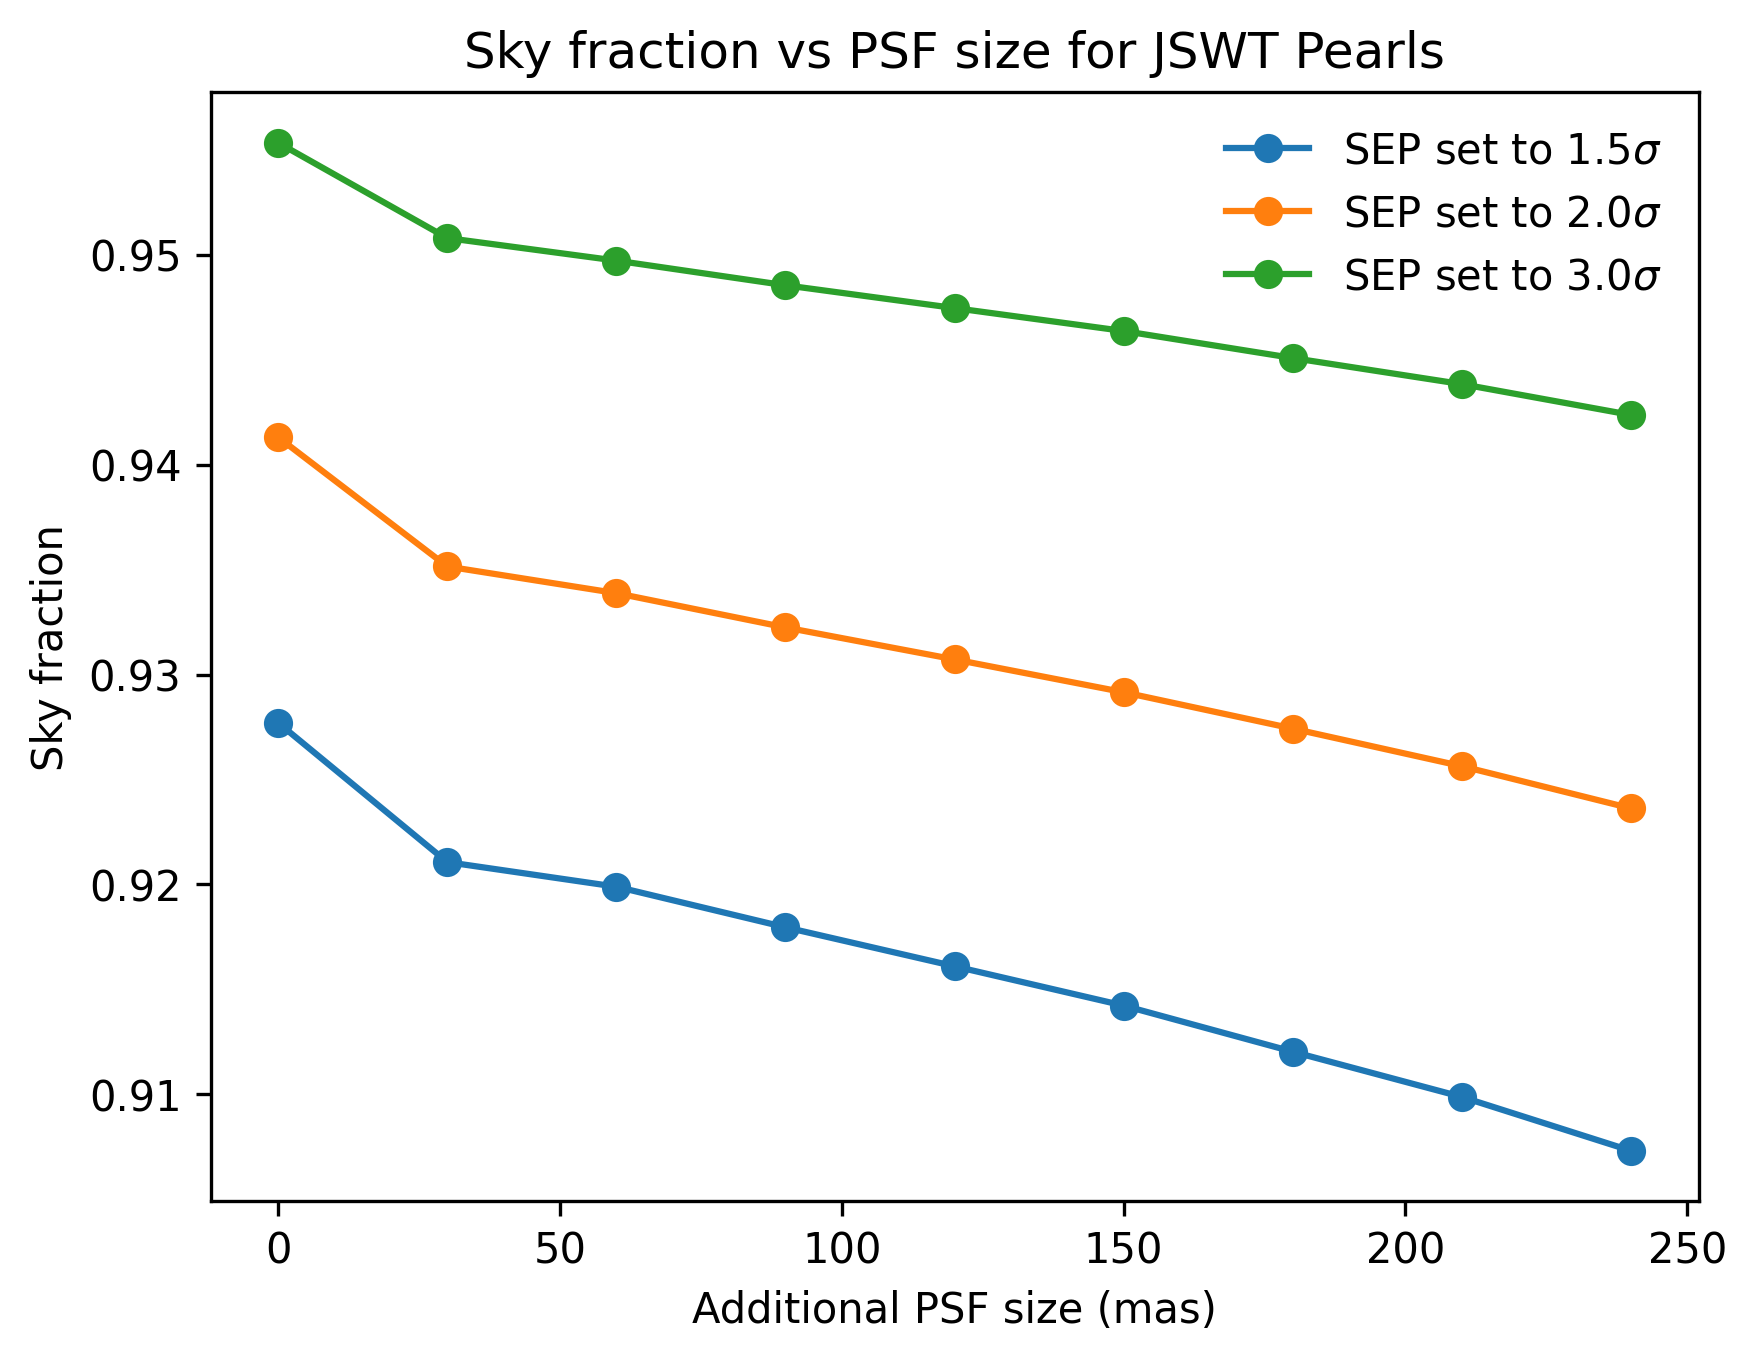

In [ ]:
fig, ax = plt.subplots()
ax.set_xlabel("Additional PSF size (mas)")
ax.set_ylabel("Sky fraction")
for (sigma, _), df_sub in df.group_by(["sep_significance", "deblend_cont"], maintain_order=True):
    ax.plot(
        df_sub["psf_mas"],
        df_sub["sky_percent"],
        marker="o",
        label=f"SEP set to {sigma}$\\sigma$",
    )
ax.set_title("Sky fraction vs PSF size for JSWT Pearls")
ax.legend(frameon=False)

output_dir = Path("output")
output_dir.mkdir(exist_ok=True)
fig.savefig(output_dir / "sky_fraction_vs_psf_size.png", dpi=200, bbox_inches="tight")